In [1]:
import pennylane as qml
from pennylane import numpy as pnp
import matplotlib.pyplot as plt

from scipy.optimize import differential_evolution, minimize
from scipy.stats.qmc import Halton

import os
import json
import numpy as np
from datetime import datetime, timedelta
import time

from susy_qm import calculate_Hamiltonian

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset, inset_axes

In [2]:
potential = "DW"
#shots = None
cutoff = 16

print(f"Running for {potential} potential and cutoff {cutoff}")

starttime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Calculate Hamiltonian and expected eigenvalues
H = calculate_Hamiltonian(cutoff, potential)
eigenvalues = np.sort(np.linalg.eig(H)[0])[:4]
min_eigenvalue = np.min(eigenvalues).real

num_qubits = int(1 + np.log2(cutoff))

Running for DW potential and cutoff 16


In [3]:
def cost_function(params, H, num_qubits, shots):
   
    dev = qml.device("default.qubit", wires=num_qubits, shots=shots)
    start = datetime.now()
  
    ############### Real Amplitudes ##########################
    @qml.qnode(dev)
    def circuit(params):
        param_index=0
        for i in range(num_qubits):
            qml.RY(params[param_index], wires=i)
            param_index += 1

        for j in reversed(range(1, num_qubits)):
            qml.CNOT(wires=[j, j-1])

        for k in range(num_qubits):
            qml.RY(params[param_index], wires=k)
            param_index += 1
        
        return qml.expval(qml.Hermitian(H, wires=range(num_qubits)))


    end = datetime.now()
    device_time = (end - start)
    
    return circuit(params), device_time

In [5]:
def run_de_vqe(bounds, max_iter, tol, abs_tol, strategy, popsize, H, num_qubits, shots, num_params):

    generation_best_energies = []
    generation_best_params = []
    generation_best_variances = []
    current_generation = [0]

    def callback(xk, convergence=None):
        # xk: best parameter set so far
        # Store best energy (res.fun will not be updated until the end, so we re-evaluate here)
        best_energy, variance, _ = cost_function(xk, H, num_qubits, shots)
        generation_best_energies.append(best_energy)
        generation_best_params.append(xk.tolist())
        generation_best_variances.append(variance)

        current_generation[0] += 1

    # We need to generate a random seed for each process otherwise each parallelised run will have the same result
    seed = (os.getpid() * int(time.time())) % 123456789
    run_start = datetime.now()

    # Generate Halton sequence
    num_dimensions = num_params
    num_samples = popsize
    halton_sampler = Halton(d=num_dimensions, seed=seed)
    halton_samples = halton_sampler.random(n=num_samples)
    scaled_samples = 2 * np.pi * halton_samples

    device_time = timedelta()

    evaluation_log = []
    def wrapped_cost_function(params):
        result, variance, dt = cost_function(params, H, num_qubits, shots)
        nonlocal device_time
        device_time += dt
        evaluation_log.append((current_generation[0], result, variance))
        return result

    # Differential Evolution optimization
    res = differential_evolution(
        wrapped_cost_function,
        bounds,
        maxiter=max_iter,
        tol=tol,
        atol=abs_tol,
        strategy=strategy,
        popsize=popsize,
        init=scaled_samples,
        seed=seed,
        callback=callback
    )

    run_end = datetime.now()
    run_time = run_end - run_start

    return {
        "seed": seed,
        "energy": res.fun,
        "params": res.x.tolist(),
        "success": bool(res.success),
        "num_iters": res.nit,
        "num_evaluations": res.nfev,
        "run_time": str(run_time),
        "device_time": str(device_time),
        "generation_best_energies": generation_best_energies,
        "generation_best_params": generation_best_params,
        "generation_best_variances": generation_best_variances,
        "evaluation_log": evaluation_log
    }

In [5]:
def run_cobyla_vqe(max_iter, tol, H, num_qubits, shots, num_params):

    iteration_energies = []
    iteration_params = []
    device_time = timedelta()

    def callback(xk):
        energy = wrapped_cost_function(xk)
        iteration_energies.append(energy)
        iteration_params.append(xk.tolist())


    device_time = timedelta()

    def wrapped_cost_function(params):
        result, dt = cost_function(params, H, num_qubits, shots)
        nonlocal device_time
        device_time += dt
        return result

    run_start = datetime.now()

    #bounds = [(0, 2 * np.pi)] * num_params
    #constraints = []
    #for i, (lower, upper) in enumerate(bounds):
    #    constraints.append({'type': 'ineq', 'fun': lambda x, i=i, lb=lower: x[i] - lb})
    #    constraints.append({'type': 'ineq', 'fun': lambda x, i=i, ub=upper: ub - x[i]})



    x0 = np.random.uniform(0, 2 * np.pi, size=num_params)

    res = minimize(
        wrapped_cost_function,
        x0=x0,
        method="COBYLA",
        callback=callback,
        #constraints=constraints,
        options={"maxiter": max_iter, "tol": tol}
    )


    run_end = datetime.now()
    run_time = run_end - run_start

    return {
        "energy": res.fun,
        "params": res.x.tolist(),
        "success": bool(res.success),
        "num_evaluations": res.nfev,
        "run_time": str(datetime.now() - run_start),
        "device_time": str(device_time),
        "iteration_energies": iteration_energies,
        "iteration_params": iteration_params
    }


In [17]:
num_params = 2*num_qubits
bounds = [(0, 2 * np.pi) for _ in range(num_params)]

num_vqe_runs = 1
max_iter = 10000
strategy = "randtobest1bin"
tol = 1e-3
abs_tol = 1e-3
popsize = 20

shots=1024

vqe_starttime = datetime.now()
de_noiseless = run_de_vqe(bounds, max_iter, tol, abs_tol, strategy, popsize, H, num_qubits, shots=None, num_params=num_params)
de_noisy = run_de_vqe(bounds, max_iter, tol, abs_tol, strategy, popsize, H, num_qubits, shots=shots, num_params=num_params)

vqe_end = datetime.now()
vqe_time = vqe_end - vqe_starttime

In [18]:
num_vqe_runs = 1
max_iter = 10000
tol = 1e-3

vqe_starttime = datetime.now()

cobyla_noiseless = run_cobyla_vqe(max_iter, tol, H, num_qubits, shots=None, num_params=num_params)
cobyla_noisy = run_cobyla_vqe(max_iter, tol, H, num_qubits, shots=shots, num_params=num_params)

vqe_end = datetime.now()
vqe_time = vqe_end - vqe_starttime

In [19]:
cobyla_noiseless['num_evaluations']

427

In [20]:
cobyla_noiseless['success']

True

In [21]:
print(cobyla_noiseless['success'], cobyla_noisy['success'], de_noiseless['success'], de_noisy['success'])

True True True True


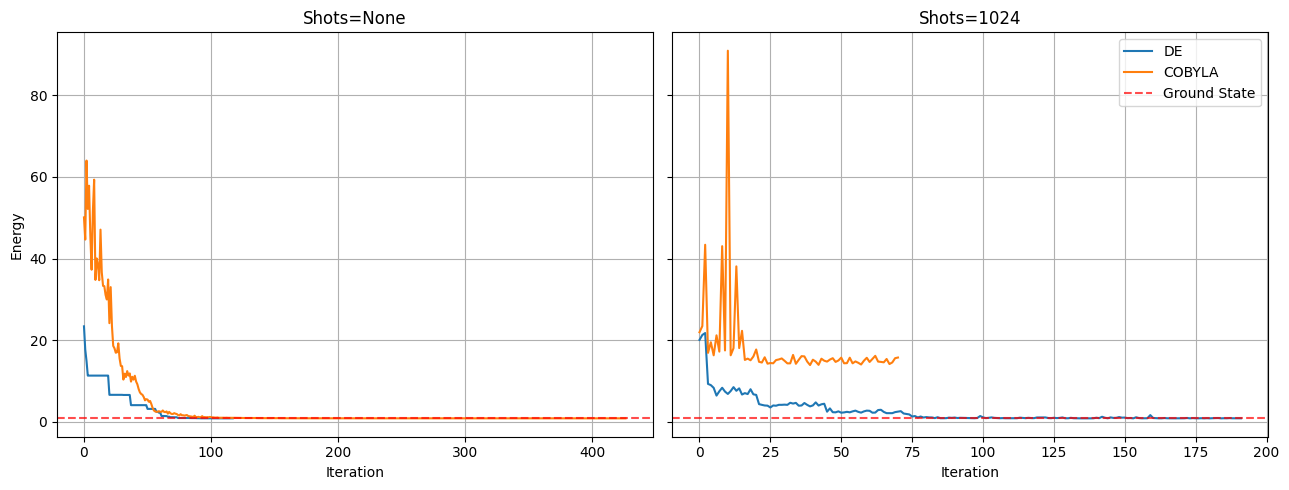

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

# ---- Noiseless ----
axes[0].plot(de_noiseless["generation_best_energies"][:300], label="DE")
axes[0].plot(cobyla_noiseless["iteration_energies"][:1111], label="COBYLA")
axes[0].axhline(y=min_eigenvalue, color='red', linestyle='--', alpha=0.7, label='Ground State')
axes[0].set_title("Shots=None")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Energy")
#axes[0].legend()
axes[0].grid(True)

# ---- Noisy ----
axes[1].plot(de_noisy["generation_best_energies"][:300], label="DE")
axes[1].plot(cobyla_noisy["iteration_energies"][:300], label="COBYLA")
axes[1].axhline(y=min_eigenvalue, color='red', linestyle='--', alpha=0.7, label='Ground State')
axes[1].set_title("Shots=1024")
axes[1].set_xlabel("Iteration")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [93]:
print(cobyla_noiseless['success'], cobyla_noisy['success'], de_noiseless['success'], de_noisy['success'])

True True True True


In [146]:
data = {"cobyla_noiseless": cobyla_noiseless,
        "cobyla_noisy": cobyla_noisy,
        "de_noiseless": de_noiseless,
        "de_noisy": de_noisy
        }

In [147]:
# Save the variable to a JSON file
base_path = r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\PennyLane\VQE\OptimizerComparison\DE-Vs-COBYLA\Data"
path = os.path.join(base_path, "{}_{}_{}.json".format(potential, cutoff, str(datetime.now().date())))
with open(path, "w") as json_file:
    json.dump(data, json_file, indent=4)

ValueError: min() iterable argument is empty

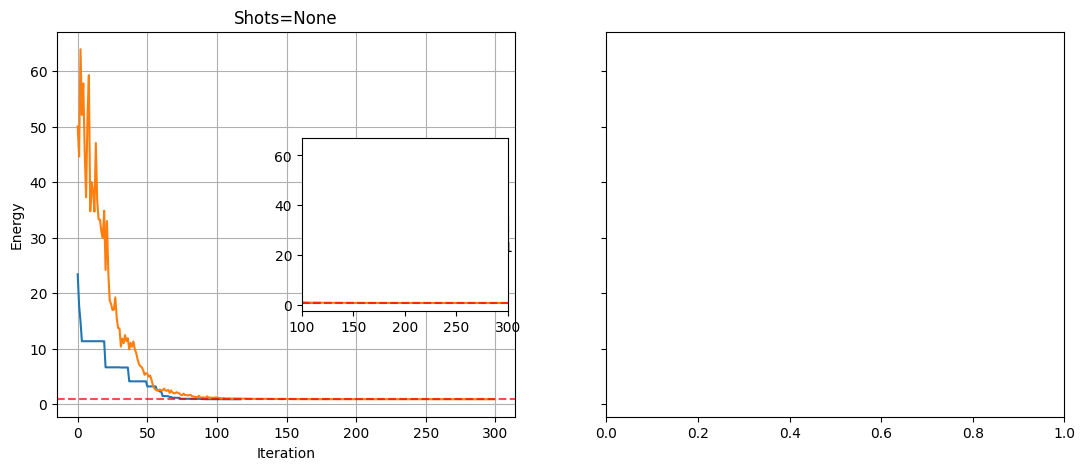

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

# ---- Noiseless ----
axes[0].plot(de_noiseless["generation_best_energies"][:300], label="DE")
axes[0].plot(cobyla_noiseless["iteration_energies"][:300], label="COBYLA")
axes[0].axhline(y=min_eigenvalue, color='red', linestyle='--', alpha=0.7, label='Ground State')
axes[0].set_title("Shots=None")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Energy")
axes[0].grid(True)

# Inset for Noiseless plot
axins0 = zoomed_inset_axes(axes[0], zoom=2.5, loc='center right')
axins0 = inset_axes(axes[0], width="45%", height="45%", loc='center right')
axins0.plot(de_noiseless["generation_best_energies"][:300])
axins0.plot(cobyla_noiseless["iteration_energies"][:300])
axins0.axhline(y=min_eigenvalue, color='red', linestyle='--', alpha=0.7)
axins0.set_xlim(100, 300)
axins0.set_ylim(
    min(min(de_noiseless["generation_best_energies"][125:175])-0.5,
        min(cobyla_noiseless["iteration_energies"][125:175]))-0.5,
    max(max(de_noiseless["generation_best_energies"][125:175])+0.5,
        max(cobyla_noiseless["iteration_energies"][125:175])+0.5)
)
axins0.set_xticks([])
axins0.set_yticks([])
mark_inset(axes[0], axins0, loc1=2, loc2=4, fc="none", ec="0.5")

# ---- Noisy ----
axes[1].plot(de_noisy["generation_best_energies"][:300], label="DE")
axes[1].plot(cobyla_noisy["iteration_energies"][:300], label="COBYLA")
axes[1].axhline(y=min_eigenvalue, color='red', linestyle='--', alpha=0.7, label='Ground State')
axes[1].set_title("Shots=1024")
axes[1].set_xlabel("Iteration")
axes[1].legend()
axes[1].grid(True)

# Inset for Noisy plot
axins1 = zoomed_inset_axes(axes[1], zoom=2.5, loc='center right')
axins1 = inset_axes(axes[1], width="45%", height="45%", loc='center right')
axins1.plot(de_noisy["generation_best_energies"][:300])
axins1.plot(cobyla_noisy["iteration_energies"][:300])
axins1.axhline(y=min_eigenvalue, color='red', linestyle='--', alpha=0.7)
axins1.set_xlim(75, 300)
axins1.set_ylim(
    min(min(de_noisy["generation_best_energies"][100:200])-0.5,
        min(cobyla_noisy["iteration_energies"][100:200]))-0.5,
    max(max(de_noisy["generation_best_energies"][100:200])+0.5,
        max(cobyla_noisy["iteration_energies"][100:200])+0.5)
)
axins1.set_xticks([])
axins1.set_yticks([])
mark_inset(axes[1], axins1, loc1=2, loc2=4, fc="none", ec="0.5")

plt.tight_layout()
plt.show()


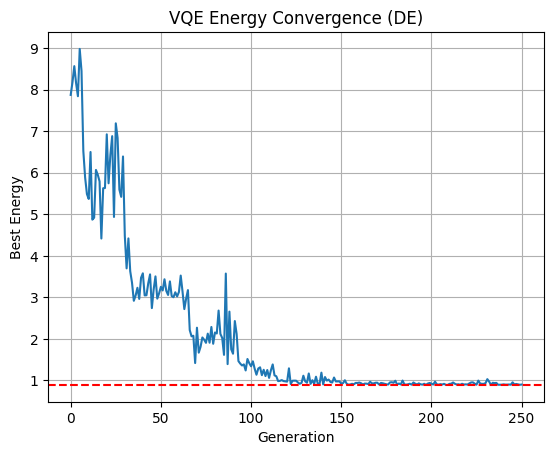

In [7]:
plt.plot(de_noisy['generation_best_energies'])
plt.axhline(y=min_eigenvalue, color='red', linestyle='--', label='Ground State')
plt.xlabel("Generation")
plt.ylabel("Best Energy")
plt.title("VQE Energy Convergence (DE)")
plt.grid(True)

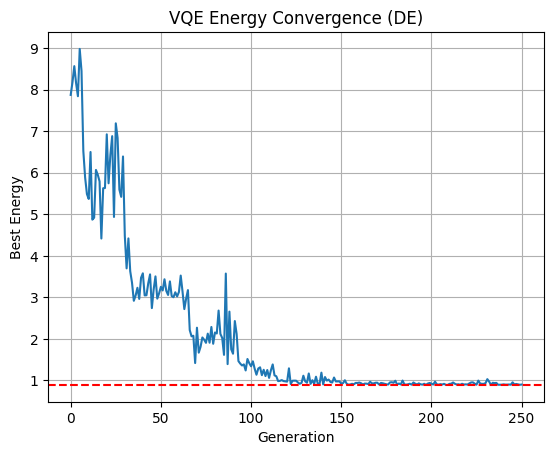

In [8]:
plt.plot(de_noisy['generation_best_energies'])
plt.axhline(y=min_eigenvalue, color='red', linestyle='--', label='Ground State')
plt.xlabel("Generation")
plt.ylabel("Best Energy")
plt.title("VQE Energy Convergence (DE)")
plt.grid(True)

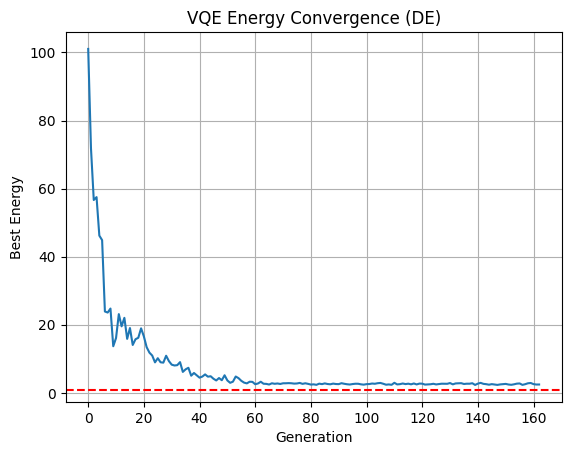

In [11]:
plt.plot(cobyla_noisy['iteration_energies'])
plt.axhline(y=min_eigenvalue, color='red', linestyle='--', label='Ground State')
plt.hlines
plt.xlabel("Generation")
plt.ylabel("Best Energy")
plt.title("VQE Energy Convergence (DE)")
plt.grid(True)

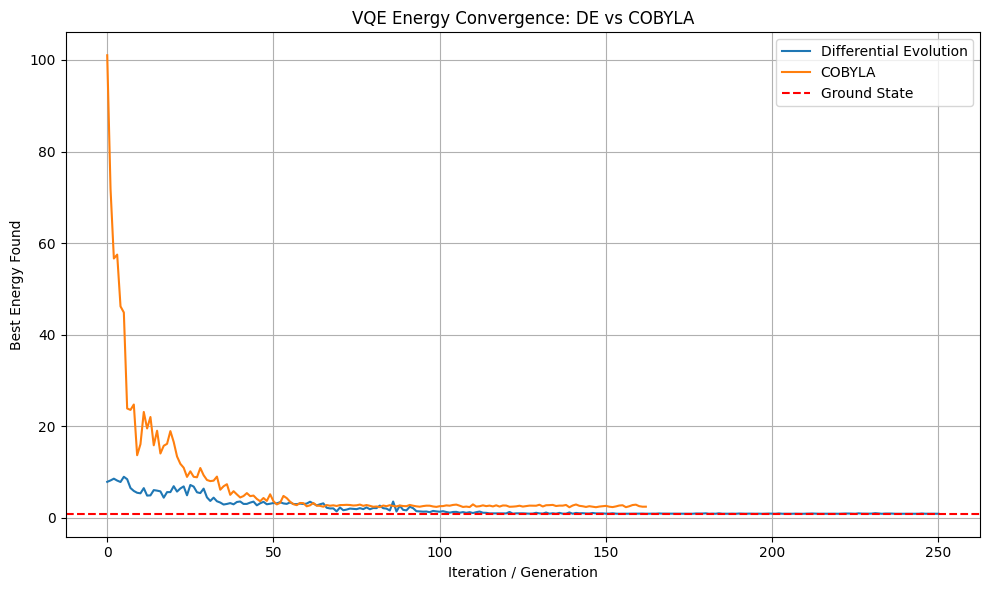

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(de_noisy['generation_best_energies'], label="Differential Evolution")#, marker='o')
plt.plot(cobyla_noisy['iteration_energies'], label="COBYLA")#, marker='x')
plt.axhline(y=min_eigenvalue, color='red', linestyle='--', label='Ground State')

plt.xlabel("Iteration / Generation")
plt.ylabel("Best Energy Found")
plt.title("VQE Energy Convergence: DE vs COBYLA")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
